In [55]:
# Summary of this project (regression)
# --------------------------------- 

# 1) Data collection from yfinance

# 2) Data Preprocessing
#      - format date
#      - remove uncessesary column  

# 3) Corelation Analysis

# 4) Outlier Detection  

# 5) Filtering Data

# 6) Feature Engineering 

# 7) Data Scalling 

# 8) Sequence Generation for LSTM 
#      - Prepare input sequences based on the look-back period  

# 9) Train-Test Split 

# 10) Model Dev

# 11) testing and evaluation 

In [2]:
import sys
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_ta as ta
import pandas_market_calendars as mcal  # Market calendar for NYSE holidays
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from datetime import datetime, timedelta


In [3]:
sys.executable

'C:\\Users\\ASUS\\OneDrive\\Documents\\Data Analytics\\Projects\\Tesla Stock Forecasting\\venv\\Scripts\\python.exe'

In [58]:
# Fetch Tesla stock data (2020 - 2025)
df = yf.download("TSLA", start="2020-01-01", end="2025-01-01")

# Reset index to move "Date" from index to a column
df.reset_index(inplace=True)

# Keep only the necessary columns and rename them correctly
df = df[["Date", "Open", "High", "Low", "Close", "Volume"]]

# Save the cleaned dataset
df.to_csv("tsla_stock_data_cleaned.csv", index=False)

df.head()

[*********************100%***********************]  1 of 1 completed


Price,Date,Open,High,Low,Close,Volume
Ticker,,TSLA,TSLA,TSLA,TSLA,TSLA
0,2020-01-02,28.299999,28.713333,28.114000,28.684000,142981500
1,2020-01-03,29.366667,30.266666,29.128000,29.534000,266677500
2,2020-01-06,29.364668,30.104000,29.333332,30.102667,151995000
3,2020-01-07,30.760000,31.441999,30.224001,31.270666,268231500
4,2020-01-08,31.580000,33.232666,31.215334,32.809334,467164500


In [59]:
# Load the CSV file and skip the first row (removing "Ticker" row)
df = pd.read_csv("tsla_stock_data_cleaned.csv", skiprows=1)

# Fix column names (remove 'TSLA' duplicates)
df.columns = ["Date", "Open", "High", "Low", "Close", "Volume"]

# Drop the "Volume" column if it exists
if "Volume" in df.columns:
    df.drop(columns=["Volume"], inplace=True)

# Convert "Date" column to proper datetime format
df["Date"] = pd.to_datetime(df["Date"], errors='coerce')

# Remove invalid datetime rows (if any)
df = df.dropna(subset=["Date"])

# Ensure Date is sorted in chronological order
df = df.sort_values("Date")

# Save the cleaned dataset
df.to_csv("tsla_stock_data_final.csv", index=False)

# Display first few rows to confirm the fix
df.head()


,Date,Open,High,Low,Close
0,2020-01-02,28.299999,28.713333,28.114000,28.684000
1,2020-01-03,29.366667,30.266666,29.128000,29.534000
2,2020-01-06,29.364668,30.104000,29.333332,30.102667
3,2020-01-07,30.760000,31.441999,30.224001,31.270666
4,2020-01-08,31.580000,33.232666,31.215334,32.809334


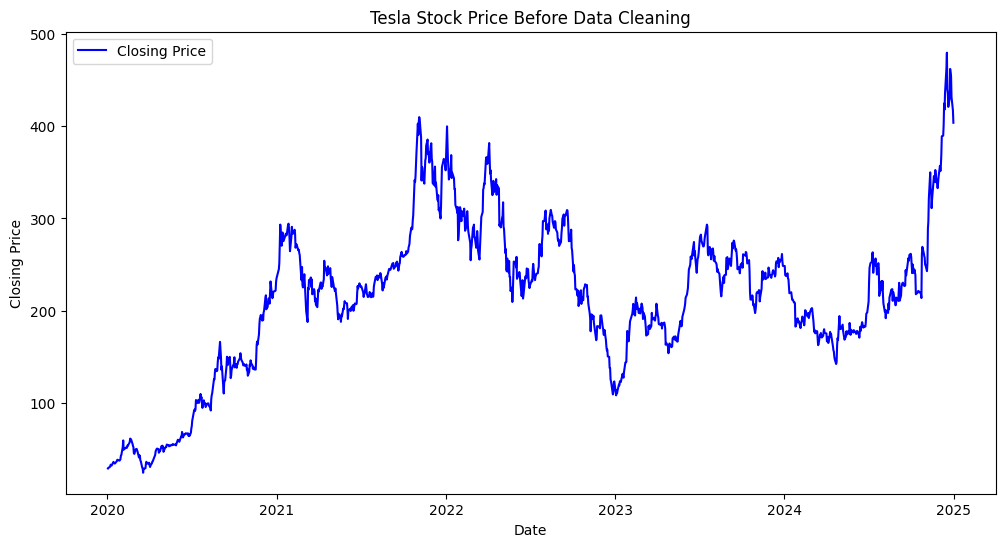

In [60]:
# Plot Tesla's stock prices before cleaning
plt.figure(figsize=(12,6))
plt.plot(df["Date"], df["Close"], label="Closing Price", color="blue")
plt.title("Tesla Stock Price Before Data Cleaning")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.show()


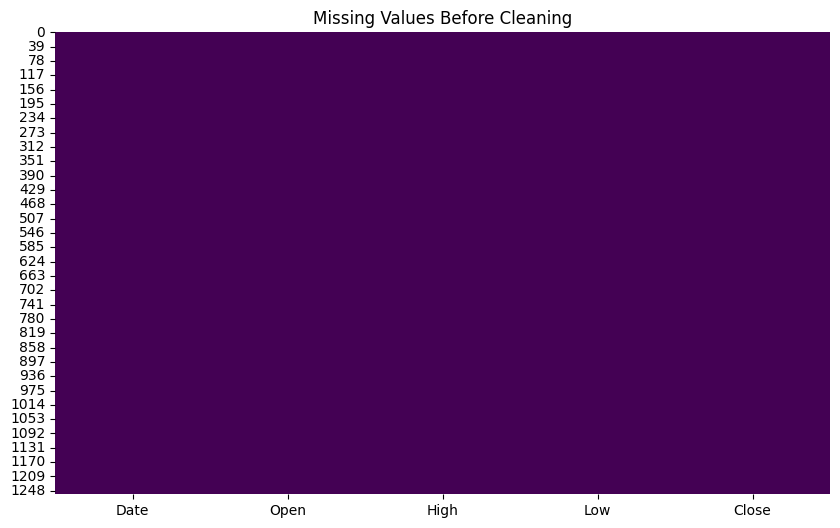

In [61]:
# Rename columns if they still contain "TSLA"
df.columns = ["Date", "Open", "High", "Low", "Close", "Volume"] if len(df.columns) == 6 else ["Date", "Open", "High", "Low", "Close"]

# Check missing values again
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Before Cleaning")
plt.show()


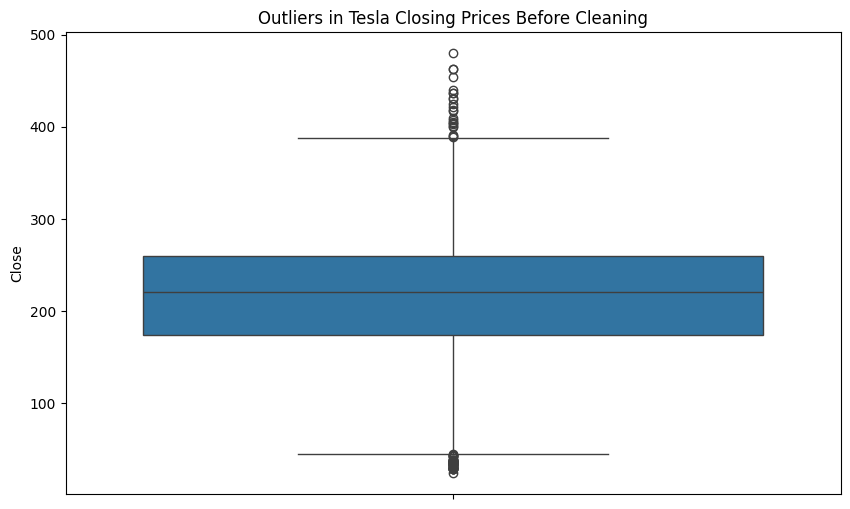

In [62]:
# Ensure "Close" column exists
if "Close" in df.columns and df["Close"].dtype != 'O':  # 'O' means object (text)
    plt.figure(figsize=(10,6))
    sns.boxplot(y=df["Close"])
    plt.title("Outliers in Tesla Closing Prices Before Cleaning")
    plt.show()
else:
    print("Error: 'Close' column not found or not numeric!")


In [63]:
# Check for missing values
print("Missing Values Before Cleaning:\n", df.isnull().sum())

# Handle missing values using forward-fill (ffill)
df.ffill(inplace=True)

# Confirm missing values are handled
print("Missing Values After Cleaning:\n", df.isnull().sum())


Missing Values Before Cleaning:
 Date     0
Open     0
High     0
Low      0
Close    0
dtype: int64
Missing Values After Cleaning:
 Date     0
Open     0
High     0
Low      0
Close    0
dtype: int64


In [64]:
# Ensure only required columns are kept
df = df[["Date", "Open", "High", "Low", "Close"]]

# Confirm final column selection
print("Final Columns:", df.columns.tolist())


Final Columns: ['Date', 'Open', 'High', 'Low', 'Close']


In [65]:
# Check for duplicate rows
print("Duplicate Rows Before:", df.duplicated().sum())

# Drop duplicates
df.drop_duplicates(inplace=True)

# Confirm duplicates are removed
print("Duplicate Rows After:", df.duplicated().sum())


Duplicate Rows Before: 0
Duplicate Rows After: 0


In [66]:
# Convert Date column to datetime format just to make sure
df["Date"] = pd.to_datetime(df["Date"])

# Sort data in chronological order
df.sort_values("Date", inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)

# Confirm Date formatting
print("Date Column Type:", df["Date"].dtype)
df.head()


Date Column Type: datetime64[ns]


,Date,Open,High,Low,Close
0,2020-01-02,28.299999,28.713333,28.114000,28.684000
1,2020-01-03,29.366667,30.266666,29.128000,29.534000
2,2020-01-06,29.364668,30.104000,29.333332,30.102667
3,2020-01-07,30.760000,31.441999,30.224001,31.270666
4,2020-01-08,31.580000,33.232666,31.215334,32.809334


In [67]:
# Calculate Interquartile Range (IQR)
Q1 = df["Close"].quantile(0.25)
Q3 = df["Close"].quantile(0.75)
IQR = Q3 - Q1

# Define acceptable range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers
outliers = df[(df["Close"] < lower_bound) | (df["Close"] > upper_bound)]
print("Number of Outliers Detected:", len(outliers))

# Remove outliers
df = df[(df["Close"] >= lower_bound) & (df["Close"] <= upper_bound)]

# Confirm outliers are removed
print("Remaining Data Points After Outlier Removal:", len(df))


Number of Outliers Detected: 70
Remaining Data Points After Outlier Removal: 1188


In [68]:
# Save the cleaned dataset
df.to_csv("tsla_stock_data_cleaned_final.csv", index=False)

print("✅ Data Cleaning Completed! Ready for Feature Engineering 🚀")


✅ Data Cleaning Completed! Ready for Feature Engineering 🚀


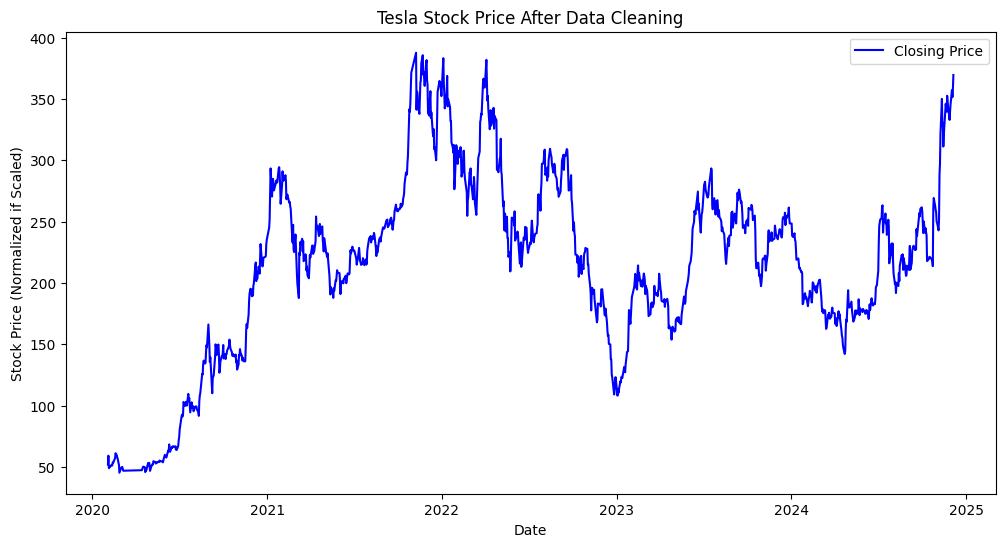

In [69]:
# Plot Tesla's stock prices after cleaning
plt.figure(figsize=(12,6))
plt.plot(df["Date"], df["Close"], label="Closing Price", color="blue")
plt.title("Tesla Stock Price After Data Cleaning")
plt.xlabel("Date")
plt.ylabel("Stock Price (Normalized if Scaled)")
plt.legend()
plt.show()


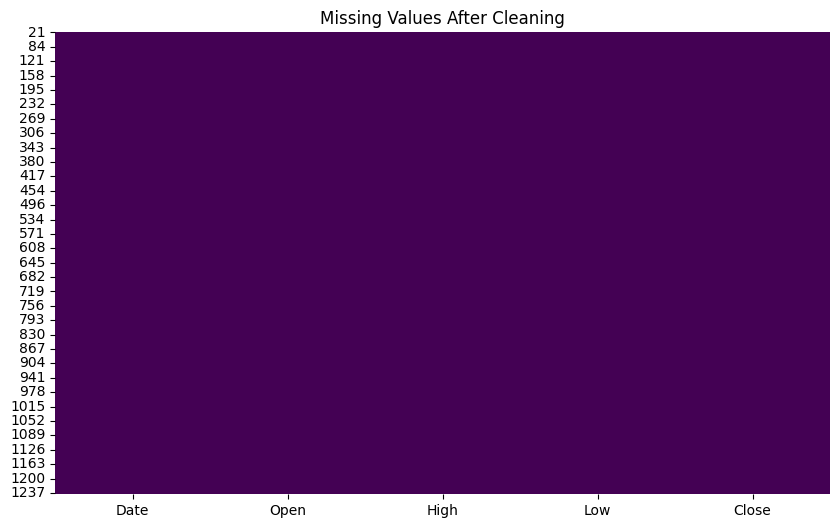

In [70]:
import seaborn as sns

# Check for missing values after cleaning
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values After Cleaning")
plt.show()


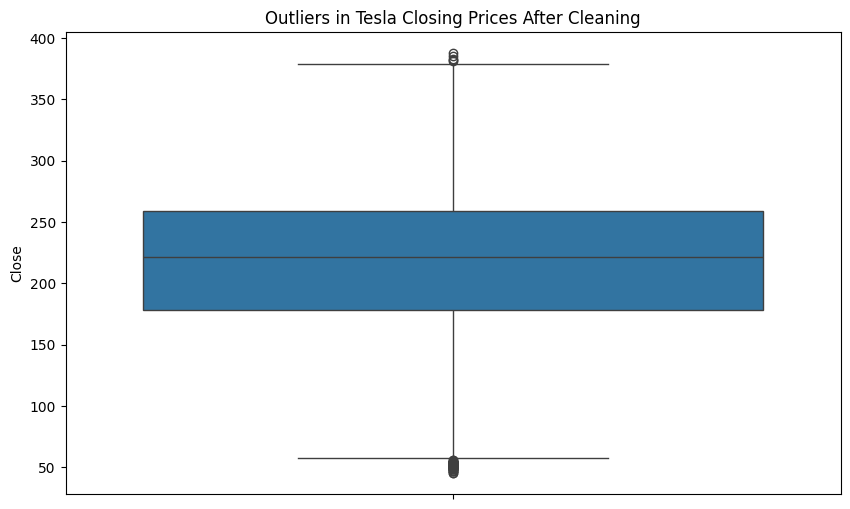

In [71]:
# Boxplot to detect remaining outliers in the Closing Price
plt.figure(figsize=(10,6))
sns.boxplot(y=df["Close"])
plt.title("Outliers in Tesla Closing Prices After Cleaning")
plt.show()


In [72]:
# Load the cleaned dataset before feature engineering
df = pd.read_csv("tsla_stock_data_cleaned_final.csv")

print("✅ Data Cleaning Completed! Ready for Feature Engineering 🚀")

# Display first few rows to confirm data is loaded
df.head()


✅ Data Cleaning Completed! Ready for Feature Engineering 🚀


,Date,Open,High,Low,Close
0,2020-02-03,44.912666,52.409332,44.901333,52.000000
1,2020-02-04,58.863998,64.599335,55.591999,59.137333
2,2020-02-05,54.883999,56.398666,46.940666,48.980000
3,2020-02-06,46.661331,53.055332,45.799999,49.930668
4,2020-02-07,48.703335,51.316666,48.666668,49.871334


In [73]:
#  Feature Engineering section(adding indicator)

In [74]:
import pandas as pd
import numpy as np
import pandas_ta as ta  # Ensure pandas_ta is imported

# Load stock data (actual file path)
df = pd.read_csv("tsla_stock_data_cleaned_final.csv")

# ✅ Calculate Simple Moving Averages (SMA)
df["50_SMA"] = df["Close"].rolling(window=50, min_periods=1).mean()
df["200_SMA"] = df["Close"].rolling(window=200, min_periods=1).mean()

# ✅ Calculate Exponential Moving Averages (EMA)
df["50_EMA"] = df["Close"].ewm(span=50, adjust=False).mean()
df["200_EMA"] = df["Close"].ewm(span=200, adjust=False).mean()

# ✅ Bollinger Bands (20-day moving average ± 2 standard deviations)
df["20_MA"] = df["Close"].rolling(window=20, min_periods=1).mean()
df["Upper_Band"] = df["20_MA"] + (2 * df["Close"].rolling(window=20, min_periods=1).std())
df["Lower_Band"] = df["20_MA"] - (2 * df["Close"].rolling(window=20, min_periods=1).std())

# ✅ RSI 14 days
df["RSI_14"] = ta.rsi(df["Close"], length=14)

# ✅ Compute daily percentage change
df["Daily_Return"] = df["Close"].pct_change()

# ✅ Move "Close" to the last position (before "Tomorrow") for LSTM training
columns = [col for col in df.columns if col != "Close"] + ["Close"]
df = df[columns]

# ✅ Create "Tomorrow" column (shift Close by -1 to predict next day's closing price)
df["Tomorrow"] = df["Close"].shift(-1)

# ✅ Drop NaN values (since the last row will have NaN in "Tomorrow")
df.dropna(inplace=True)

# ✅ Reset index after dropping NaNs
df.reset_index(drop=True, inplace=True)

# ✅ Display first few rows to confirm changes
df.head()


,Date,Open,High,Low,50_SMA,200_SMA,50_EMA,200_EMA,20_MA,Upper_Band,Lower_Band,RSI_14,Daily_Return,Close,Tomorrow
0,2020-02-24,55.933334,57.566666,54.813332,54.336844,54.336844,53.251476,52.340363,54.336844,62.704346,45.969342,53.602005,-0.074595,55.585999,53.327332
1,2020-02-25,56.599998,57.106667,52.466667,54.273750,54.273750,53.254451,52.350183,54.273750,62.373268,46.174232,48.253692,-0.040634,53.327332,51.919998
2,2020-02-26,52.166668,54.220669,51.740665,54.135294,54.135294,53.202119,52.345903,54.135294,62.060293,46.210294,45.225726,-0.026390,51.919998,45.266666
3,2020-02-27,48.666668,49.318001,44.599998,53.642592,53.642592,52.890925,52.275463,53.642592,62.394136,44.891049,34.275349,-0.128146,45.266666,49.574669
4,2020-03-02,47.417332,49.579334,45.778000,53.428491,53.428491,52.760876,52.248589,53.428491,62.135863,44.721119,43.769141,0.095169,49.574669,49.700668


In [75]:
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.expand_frame_repr", False)  # Prevent wrapping
pd.set_option("display.float_format", "{:.6f}".format)  # Format float numbers neatly

In [76]:
# Separate the last row (used for future prediction)
last_row = df.iloc[-1:].copy()  # Keep a copy of the last row

# Remove the last row from the dataframe (so it's not used in training)
df.loc[df.index[-1], "Tomorrow"]  # Displays full precision of last row

# Display the dataset after removing the last row
df.head(), last_row


(         Date      Open      High       Low    50_SMA   200_SMA    50_EMA   200_EMA     20_MA  Upper_Band  Lower_Band    RSI_14  Daily_Return     Close  Tomorrow
 0  2020-02-24 55.933334 57.566666 54.813332 54.336844 54.336844 53.251476 52.340363 54.336844   62.704346   45.969342 53.602005     -0.074595 55.585999 53.327332
 1  2020-02-25 56.599998 57.106667 52.466667 54.273750 54.273750 53.254451 52.350183 54.273750   62.373268   46.174232 48.253692     -0.040634 53.327332 51.919998
 2  2020-02-26 52.166668 54.220669 51.740665 54.135294 54.135294 53.202119 52.345903 54.135294   62.060293   46.210294 45.225726     -0.026390 51.919998 45.266666
 3  2020-02-27 48.666668 49.318001 44.599998 53.642592 53.642592 52.890925 52.275463 53.642592   62.394136   44.891049 34.275349     -0.128146 45.266666 49.574669
 4  2020-03-02 47.417332 49.579334 45.778000 53.428491 53.428491 52.760876 52.248589 53.428491   62.135863   44.721119 43.769141      0.095169 49.574669 49.700668,
             Date    

In [77]:
last_row

,Date,Open,High,Low,50_SMA,200_SMA,50_EMA,200_EMA,20_MA,Upper_Band,Lower_Band,RSI_14,Daily_Return,Close,Tomorrow
1172,2024-12-04,353.000000,358.100006,348.600006,279.122200,217.194100,291.885327,239.285099,334.378500,372.165941,296.591060,66.199423,0.018525,357.929993,369.489990


In [78]:
# Save the dataset after feature engineering
df.to_csv("tsla_stock_data_featured.csv", index=False)

print("✅ Feature Engineering Completed! Ready for Model Training 🚀")


✅ Feature Engineering Completed! Ready for Model Training 🚀


In [79]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# ✅ Load the original dataset (unchanged)
df = pd.read_csv("tsla_stock_data_featured.csv")

# ✅ Ensure "Date" column remains unchanged
if "Date" in df.columns:
    date_column = df["Date"]  # Store Date separately
    df = df.drop(columns=["Date"])  # Remove Date before normalization
else:
    date_column = None

# ✅ Initialize MinMaxScaler (0 to 1 range)
scaler = MinMaxScaler(feature_range=(0, 1))

# ✅ Apply MinMaxScaler only to numerical columns
df[df.columns] = scaler.fit_transform(df[df.columns])

# ✅ Restore the Date column after normalization
if date_column is not None:
    df.insert(0, "Date", date_column)  # Insert Date back in the first column

# ✅ Save the normalized dataset while preserving Date format
df.to_csv("tsla_stock_data_scaled.csv", index=False)

# ✅ Display first few rows of the scaled dataset
print("✅ Normalization Completed! Date format preserved. 🚀")
df.head()


✅ Normalization Completed! Date format preserved. 🚀


,Date,Open,High,Low,50_SMA,200_SMA,50_EMA,200_EMA,20_MA,Upper_Band,Lower_Band,RSI_14,Daily_Return,Close,Tomorrow
0,2020-02-24,0.028339,0.029346,0.030665,0.009794,0.011811,0.007779,0.002415,0.016593,0.025788,0.015224,0.482248,0.316490,0.030140,0.023543
1,2020-02-25,0.030241,0.028052,0.023619,0.009584,0.011557,0.007789,0.002455,0.016393,0.024851,0.015921,0.412611,0.395503,0.023543,0.019433
2,2020-02-26,0.017593,0.019934,0.021439,0.009123,0.011001,0.007607,0.002437,0.015954,0.023965,0.016043,0.373186,0.428641,0.019433,0.000000
3,2020-02-27,0.007608,0.006145,0.000000,0.007483,0.009024,0.006527,0.002148,0.014391,0.024910,0.011560,0.230607,0.191901,0.000000,0.012583
4,2020-03-02,0.004044,0.006880,0.003537,0.006770,0.008164,0.006075,0.002038,0.013711,0.024179,0.010982,0.354220,0.711458,0.012583,0.012951


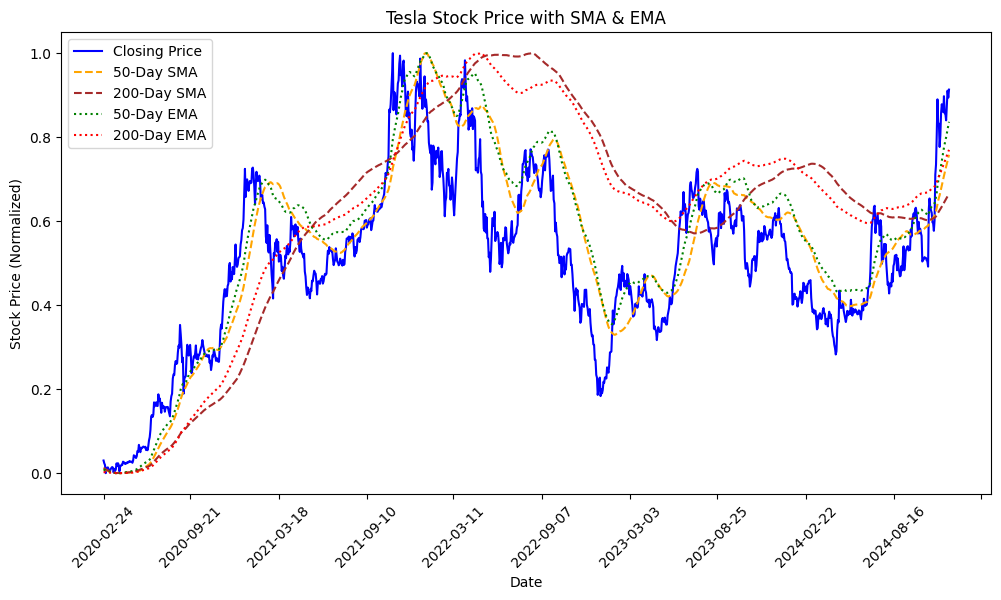

In [80]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot stock prices with moving averages
plt.figure(figsize=(12,6))
plt.plot(df["Date"], df["Close"], label="Closing Price", color="blue")
plt.plot(df["Date"], df["50_SMA"], label="50-Day SMA", linestyle="dashed", color="orange")
plt.plot(df["Date"], df["200_SMA"], label="200-Day SMA", linestyle="dashed", color="brown")
plt.plot(df["Date"], df["50_EMA"], label="50-Day EMA", linestyle="dotted", color="green")
plt.plot(df["Date"], df["200_EMA"], label="200-Day EMA", linestyle="dotted", color="red")

# Set title and labels
plt.title("Tesla Stock Price with SMA & EMA")
plt.xlabel("Date")
plt.ylabel("Stock Price (Normalized)")

# Format x-axis for better readability
plt.xticks(rotation=45)  # Rotate labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto spacing of dates
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # Format as Year-Month

# Add legend
plt.legend()

# Show plot
plt.show()


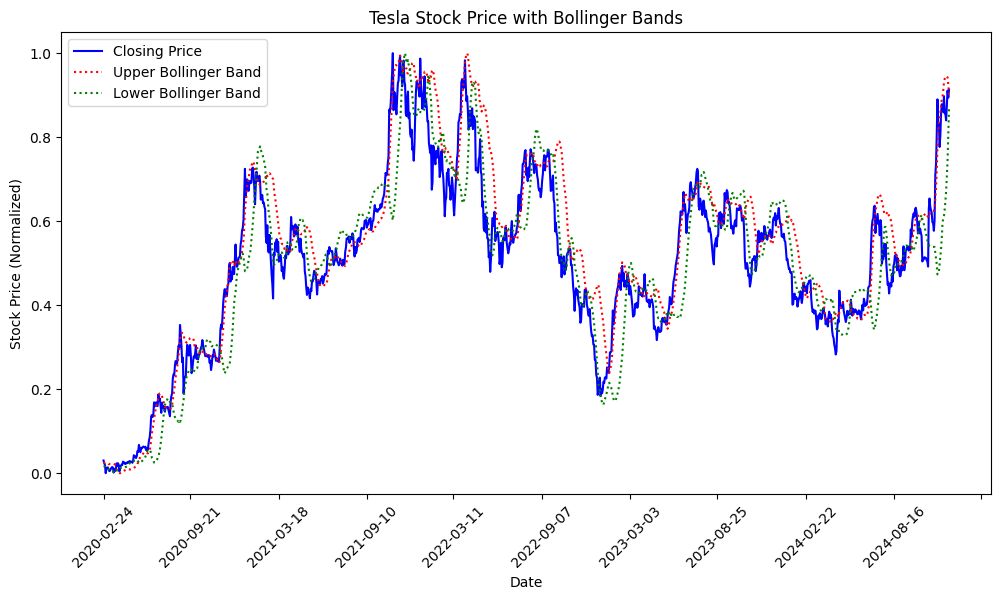

In [81]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot Bollinger Bands
plt.figure(figsize=(12,6))
plt.plot(df["Date"], df["Close"], label="Closing Price", color="blue")
plt.plot(df["Date"], df["Upper_Band"], label="Upper Bollinger Band", linestyle="dotted", color="red")
plt.plot(df["Date"], df["Lower_Band"], label="Lower Bollinger Band", linestyle="dotted", color="green")

# Set title and labels
plt.title("Tesla Stock Price with Bollinger Bands")
plt.xlabel("Date")
plt.ylabel("Stock Price (Normalized)")

# Format x-axis for better readability
plt.xticks(rotation=45)  # Rotate labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto spacing of dates
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%M"))  # Format as Year-Month

# Add legend
plt.legend()

# Show plot
plt.show()


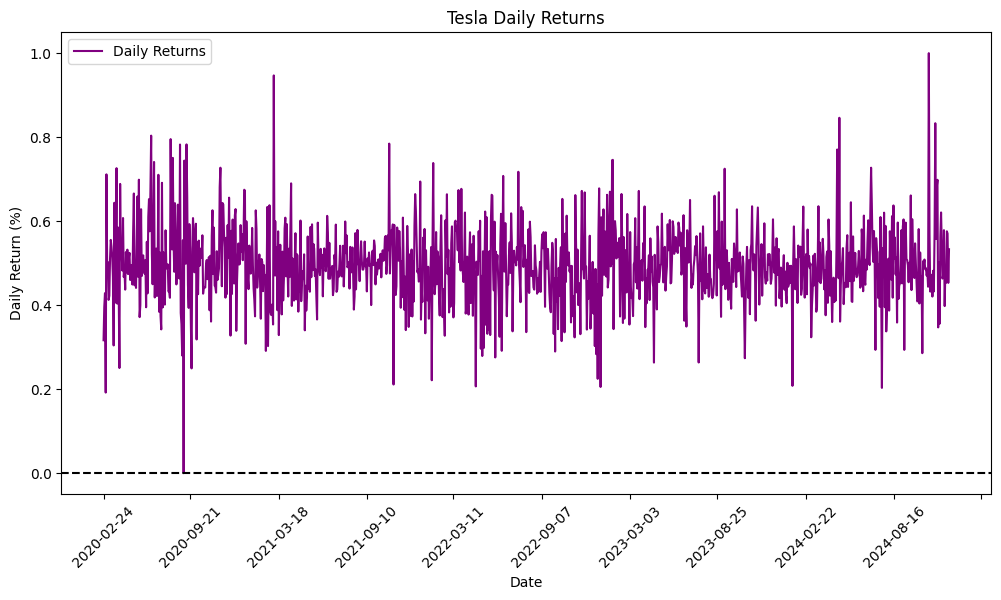

In [82]:
# Plot daily returns to visualize stock price fluctuations
plt.figure(figsize=(12,6))
plt.plot(df["Date"], df["Daily_Return"], label="Daily Returns", color="purple")
plt.axhline(0, color="black", linestyle="dashed")  # Reference line for 0 return
plt.title("Tesla Daily Returns")
plt.xlabel("Date")
plt.ylabel("Daily Return (%)")

# Format x-axis for better readability
plt.xticks(rotation=45)  # Rotate labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto spacing of dates
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%M"))  # Format as Year-Month

plt.legend()
plt.show()


In [83]:
import pandas as pd

# Load your dataset (Replace with your actual file path)
df = pd.read_csv("tsla_stock_data_scaled.csv")

# Display the first few rows
print(df.head())


         Date     Open     High      Low   50_SMA  200_SMA   50_EMA  200_EMA    20_MA  Upper_Band  Lower_Band   RSI_14  Daily_Return    Close  Tomorrow
0  2020-02-24 0.028339 0.029346 0.030665 0.009794 0.011811 0.007779 0.002415 0.016593    0.025788    0.015224 0.482248      0.316490 0.030140  0.023543
1  2020-02-25 0.030241 0.028052 0.023619 0.009584 0.011557 0.007789 0.002455 0.016393    0.024851    0.015921 0.412611      0.395503 0.023543  0.019433
2  2020-02-26 0.017593 0.019934 0.021439 0.009123 0.011001 0.007607 0.002437 0.015954    0.023965    0.016043 0.373186      0.428641 0.019433  0.000000
3  2020-02-27 0.007608 0.006145 0.000000 0.007483 0.009024 0.006527 0.002148 0.014391    0.024910    0.011560 0.230607      0.191901 0.000000  0.012583
4  2020-03-02 0.004044 0.006880 0.003537 0.006770 0.008164 0.006075 0.002038 0.013711    0.024179    0.010982 0.354220      0.711458 0.012583  0.012951


In [84]:
import numpy as np
import pandas as pd

# ✅ Load the normalized dataset
df = pd.read_csv("tsla_stock_data_scaled.csv")

# ✅ Define Lookback Period (90 Days)
look_back_days = 90

# ✅ Select Features for Training (Excluding "Date" and "Tomorrow")
feature_columns = ["Open", "High", "Low", "50_SMA", "200_SMA", "50_EMA", "200_EMA", "Close"]
target_column = "Tomorrow"

# ✅ Convert to NumPy array for processing
stock_data_scaled = df[feature_columns + [target_column]].values  # Ensure the last column is "Tomorrow"

# ✅ Initialize an empty list for input sequences
input_sequences = []

# ✅ Loop through each feature to create lookback sequences
for feature_index in range(len(feature_columns)):  
    input_sequences.append([])  # Create a new sublist for each feature
    
    # ✅ Loop over each day in the dataset, starting from the 90th day
    for current_day in range(look_back_days, stock_data_scaled.shape[0]):
        # ✅ Collect the last 90 days of data for this feature
        input_sequences[feature_index].append(stock_data_scaled[current_day - look_back_days:current_day, feature_index])

# ✅ Convert list to NumPy array
input_sequences = np.array(input_sequences)

# ✅ Reshape to be (samples, time_steps, features) for LSTM
x_feature_reshape = np.moveaxis(input_sequences, [0], [2])

# ✅ Prepare the target variable ('Tomorrow')
y_target_reshape = np.array(stock_data_scaled[look_back_days:, -1])  # -1 index is "Tomorrow"

# ✅ Reshape y_target to be a 2D array (required for LSTM)
y_target_reshaped = np.reshape(y_target_reshape, (len(y_target_reshape), 1))

# ✅ Print Shapes to Verify Data Structure
print("Training feature reshape")
print("---------------------------------------")
print(x_feature_reshape.shape)  # Expected Shape: (samples, 90, 8)

print("Target feature reshape")
print("---------------------------------------")
print(y_target_reshaped.shape)  # Expected Shape: (samples, 1)


Training feature reshape
---------------------------------------
(1083, 90, 8)
Target feature reshape
---------------------------------------
(1083, 1)


In [85]:
# ✅ Define the split limit at 80% of the dataset length
split_limit = int(len(x_feature_reshape) * 0.8)

# ✅ Split the input sequences into training and testing sets
X_train, X_test = x_feature_reshape[:split_limit], x_feature_reshape[split_limit:]

# ✅ Split the target values into training and testing sets
y_train, y_test = y_target_reshaped[:split_limit], y_target_reshaped[split_limit:]

# ✅ Print the shapes of the training and testing sets to ensure the split was successful
print("X_train shape:", X_train.shape)  # Expected: (80% of samples, 90, 8)
print("X_test shape:", X_test.shape)    # Expected: (20% of samples, 90, 8)
print("y_train shape:", y_train.shape)  # Expected: (80% of samples, 1)
print("y_test shape:", y_test.shape)    # Expected: (20% of samples, 1)

# ✅ Output the first few training targets to verify the split
print("First 10 Training Targets:", y_train[:10].flatten())  # Display first 10 values for verification


X_train shape: (866, 90, 8)
X_test shape: (217, 90, 8)
y_train shape: (866, 1)
y_test shape: (217, 1)
First 10 Training Targets: [0.14400569 0.13540316 0.17052398 0.18342193 0.18920692 0.22521565
 0.23523376 0.233567   0.25757542 0.26695094]


In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense

# ✅ Define the LSTM model
model = Sequential()

# ✅ Explicitly Define Input Layer
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

# ✅ First LSTM Layer
model.add(LSTM(units=50, return_sequences=True))

# ✅ Second LSTM Layer
model.add(LSTM(units=50))

# ✅ Output Layer (1 neuron for predicting "Tomorrow" closing price)
model.add(Dense(1))

# ✅ Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# ✅ Train the model
history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_test, y_test)
)

# ✅ Print summary of the model
model.summary()


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.0774 - val_loss: 0.0143
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0085 - val_loss: 0.0063
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0055 - val_loss: 0.0046
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 90, 50)              │          11,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,155 (375.61 KB)

 Trainable params: 32,051 (125.20 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 64,104 (250.41 KB)

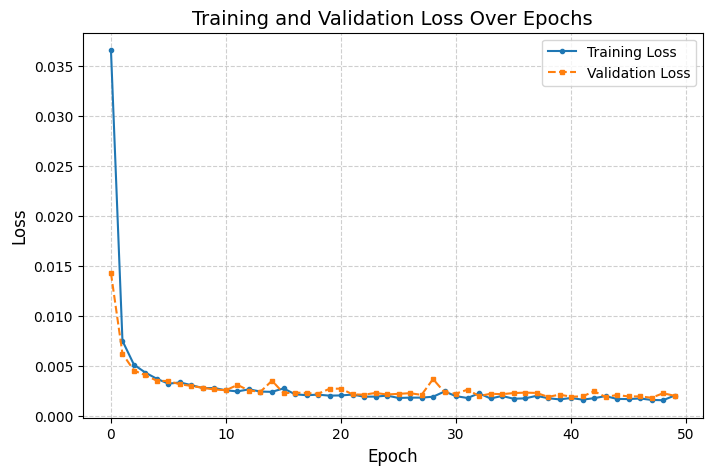

In [87]:
import matplotlib.pyplot as plt

# ✅ Extract loss and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# ✅ Create a new figure
plt.figure(figsize=(8, 5))  # Slightly bigger for better visibility

# ✅ Plot training and validation loss
plt.plot(train_loss, label='Training Loss', linestyle='solid', marker='o', markersize=3)
plt.plot(val_loss, label='Validation Loss', linestyle='dashed', marker='s', markersize=3)

# ✅ Add title and labels
plt.title('Training and Validation Loss Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# ✅ Add a legend
plt.legend()

# ✅ Show the plot
plt.grid(True, linestyle='--', alpha=0.6)  # Add grid for better readability
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step 
✅ Model Evaluation Metrics:
Mean Squared Error (MSE): 0.0015
Mean Absolute Error (MAE): 0.0299
R-squared (R²): 0.9013


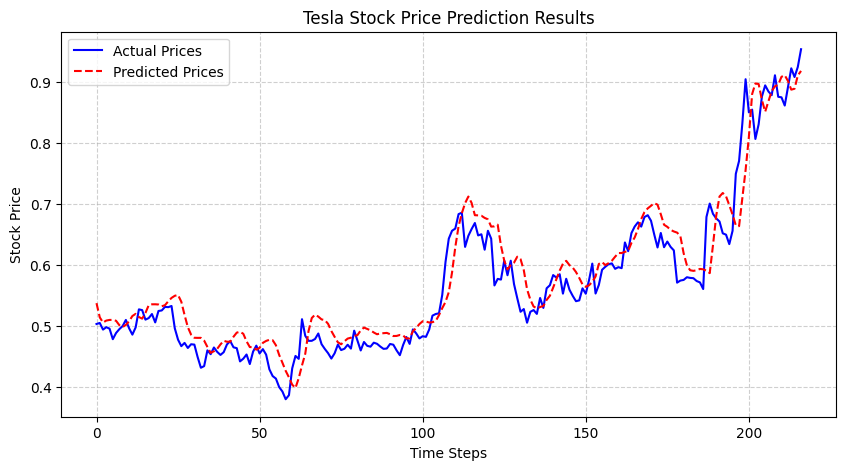

In [88]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# ✅ Predict on the test data
y_pred_scaled = model.predict(X_test)

# ✅ Reshape y_pred_scaled to match the shape of y_test for evaluation
y_pred_scaled = np.reshape(y_pred_scaled, (len(y_pred_scaled),))

# ✅ Assuming 'y_target_reshaped' was scaled similarly to the features:
# Create a reverse scaler for the target variable
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(y_target_reshaped.reshape(-1, 1))

# ✅ Inverse transform predictions and actual test targets to get real stock prices
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = target_scaler.inverse_transform(y_test)

# ✅ Calculate evaluation metrics
mse = mean_squared_error(y_test_actual, y_pred)
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

# ✅ Print evaluation metrics
print("✅ Model Evaluation Metrics:")
print("Mean Squared Error (MSE):", round(mse, 4))
print("Mean Absolute Error (MAE):", round(mae, 4))
print("R-squared (R²):", round(r2, 4))

# ✅ Visualize the predictions vs actual values
plt.figure(figsize=(10, 5))

# ✅ Plot actual stock prices
plt.plot(y_test_actual, label='Actual Prices', color='blue')

# ✅ Plot predicted stock prices
plt.plot(y_pred, label='Predicted Prices', color='red', linestyle='--')  # Dashed line for predictions

# ✅ Set plot title and labels
plt.title('Tesla Stock Price Prediction Results')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)  # Add grid for better readability

# ✅ Show the plot
plt.show()


In [89]:
# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 90, 50)              │          11,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,155 (375.61 KB)

 Trainable params: 32,051 (125.20 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 64,104 (250.41 KB)

In [90]:
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.expand_frame_repr", False)  # Prevent wrapping
pd.set_option("display.float_format", "{:.6f}".format)  # Format float numbers neatly

In [91]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# ✅ Load the dataset
df = pd.read_csv("tsla_stock_data_featured.csv")

# ✅ Ensure "Tomorrow" column exists for inverse scaling
target_column = "Tomorrow"

# ✅ Fit the scaler on the original target values
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(df[[target_column]].values)  # Fit scaler on 'Tomorrow' column

# ✅ Extract the test data indices
test_indices = df.index[-len(X_test):]

# ✅ Create a DataFrame for the test data
test_df = df.loc[test_indices].copy()

# ✅ Predict on the test data
y_pred_scaled = model.predict(X_test)

# ✅ Reshape y_pred_scaled to match the shape of y_test for evaluation
y_pred_scaled = np.reshape(y_pred_scaled, (len(y_pred_scaled),))

# ✅ Inverse transform predictions to get them back to the original scale
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

# ✅ Add the predictions as a new column to the DataFrame
test_df["Predicted"] = y_pred

# ✅ Display first few rows (Jupyter Notebook or Console)
print("✅ First 10 rows of test data with predictions:")
print(test_df.head(10))

# ✅ Save the predictions to a CSV file
test_df.to_csv("tsla_test_predictions.csv", index=False)
print("✅ Test Data with Predictions saved as 'tsla_test_predictions.csv'")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
✅ First 10 rows of test data with predictions:
           Date       Open       High        Low     50_SMA    200_SMA     50_EMA    200_EMA      20_MA  Upper_Band  Lower_Band    RSI_14  Daily_Return      Close   Tomorrow  Predicted
956  2024-01-26 185.500000 186.779999 182.100006 235.466200 231.964200 229.343592 231.443280 223.529501  263.564630  183.494371 18.202359      0.003395 183.250000 190.929993 204.482742
957  2024-01-29 185.630005 191.479996 183.669998 234.536600 232.016150 227.837176 231.040162 220.417001  260.425363  180.408638 27.298390      0.041910 190.929993 191.589996 195.234222
958  2024-01-30 195.330002 196.360001 190.610001 233.511600 232.044600 226.415718 230.647623 217.572501  257.268235  177.876766 28.038982      0.003457 191.589996 187.289993 191.883667
959  2024-01-31 187.000000 193.970001 185.850006 232.585600 232.056050 224.881376 230.216204 214.516000  253.620280  175.411721 26.168632     -0.022444 187.289993 188.860001 1

In [92]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# ✅ Ensure the feature scaler is fitted on the original training data
# Feature scaler for the features used in training
feature_columns = ["Open", "High", "Low", "50_SMA", "200_SMA", "50_EMA", "200_EMA", "Close"]
feature_scaler = MinMaxScaler(feature_range=(0, 1))
feature_scaler.fit(df[feature_columns])  # Fit the scaler on the full dataset features

# ✅ Transform the last_row data
last_row_scaled = feature_scaler.transform(last_row[feature_columns])

# ✅ Prepare the data for prediction
# As we need a sequence of look_back_days, repeat the last_row_scaled to form the sequence
look_back_days = 90  # Same look_back_days used in training
input_sequence = np.array([last_row_scaled] * look_back_days)

# ✅ Reshape to be (samples, time_steps, features) for LSTM
input_sequence = np.reshape(input_sequence, (1, look_back_days, last_row_scaled.shape[1]))

# ✅ Predict the 'tomorrow' value
predicted_scaled = model.predict(input_sequence)

# ✅ Reshape prediction to match the scaler input shape
predicted_scaled = np.reshape(predicted_scaled, (1,))

# ✅ Create a target scaler fitted on the 'Tomorrow' column of the dataset
# Fit the scaler on non-NaN values of 'Tomorrow'
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(df[['Tomorrow']].dropna().values.reshape(-1, 1))

# ✅ Inverse transform the prediction to get the real stock price
predicted = target_scaler.inverse_transform(predicted_scaled.reshape(-1, 1))

# ✅ Print the predicted value
predicted_price = predicted[0][0]
print(f"✅ Predicted 'Tomorrow' stock price for {last_row.index[0]}: {predicted_price}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
✅ Predicted 'Tomorrow' stock price for 1172: 360.0046081542969


In [93]:
# Save the trained LSTM model to an HDF5 file
model.save('lstm_tesla_stock_model.h5')
model.save('lstm_tesla_stock_model.keras')

print("Model saved successfully!")

Model saved successfully!


In [7]:
# ✅ Load the trained LSTM model
model = load_model("lstm_tesla_stock_model.h5")  # Ensure your trained model is saved
model.compile(optimizer='adam', loss='mean_squared_error') #removes the warning about compiled metrics.

# ✅ Fetch Real-Time Tesla Stock Data
ticker = "TSLA"
stock_data = yf.download(ticker, period="100d", interval="1d", auto_adjust=True)  # Get last 100 days

# ✅ Keep only relevant features (same as CSV features)
stock_data = stock_data[["Open", "High", "Low", "Close"]]

# ✅ Calculate Indicators (Same as Training Data)
stock_data["50_SMA"] = stock_data["Close"].rolling(window=50, min_periods=1).mean()
stock_data["200_SMA"] = stock_data["Close"].rolling(window=200, min_periods=1).mean()
stock_data["50_EMA"] = stock_data["Close"].ewm(span=50, adjust=False).mean()
stock_data["200_EMA"] = stock_data["Close"].ewm(span=200, adjust=False).mean()

# ✅ Drop NaN values after calculating indicators
stock_data.dropna(inplace=True)

# ✅ Load the feature scaler (previously used during training)
feature_columns = ["Open", "High", "Low", "50_SMA", "200_SMA", "50_EMA", "200_EMA", "Close"]
feature_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler on the same columns from the training data
feature_scaler.fit(stock_data[feature_columns])

# ✅ Select the last row (latest stock prices)
last_row = stock_data.iloc[-1:][feature_columns]

# ✅ Get the latest stock market date & predict for the next trading day
latest_date = stock_data.index[-1]  # Last available market trading date
predicted_date = latest_date + timedelta(days=1)  # Assume next day

# ✅ Get NYSE Market Holidays
nyse = mcal.get_calendar("NYSE")
holidays = nyse.valid_days(start_date=latest_date.strftime("%Y-%m-%d"), end_date=(latest_date + timedelta(days=365)).strftime("%Y-%m-%d"))

# ✅ Ensure predicted date is a valid market day (skip weekends & holidays)
while predicted_date.weekday() in [5, 6] or predicted_date.strftime("%Y-%m-%d") not in holidays.strftime("%Y-%m-%d").tolist():
    predicted_date += timedelta(days=1)  # Move to next available trading day

# ✅ Scale the last row for LSTM input
last_row_scaled = feature_scaler.transform(last_row)

# ✅ Prepare input sequence for prediction (repeat last row for 90 lookback days)
look_back_days = 90
input_sequence = np.array([last_row_scaled] * look_back_days)

# ✅ Reshape input for LSTM
input_sequence = np.reshape(input_sequence, (1, look_back_days, last_row_scaled.shape[1]))

# ✅ Predict the 'Tomorrow' stock price (scaled)
predicted_scaled = model.predict(input_sequence)

# ✅ Reshape prediction
predicted_scaled = np.reshape(predicted_scaled, (1,))

# ✅ Load the target scaler (used for inverse transformation)
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(stock_data[["Close"]])  # Fit on Close price as "Tomorrow" column doesn't exist in live data

# ✅ Inverse transform prediction to get actual stock price
predicted_price = target_scaler.inverse_transform(predicted_scaled.reshape(-1, 1))[0][0]

# ✅ Get the current timestamp for when prediction is made
current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# ✅ Display Forecasted Tesla Stock Price for Tomorrow with Date & Time
print("🚀 Tesla Stock Price Prediction")
print(f"📅 Predicted Market Trading Day: {predicted_date.strftime('%Y-%m-%d')}")
print(f"⏰ Prediction Made At: {current_time}")
print(f"💰 Predicted Tesla Stock Price: ${predicted_price:.2f}")


[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
🚀 Tesla Stock Price Prediction
📅 Predicted Market Trading Day: 2025-03-10
⏰ Prediction Made At: 2025-03-08 17:56:22
💰 Predicted Tesla Stock Price: $261.35
